# Base Code using YOLOv1

reference: https://github.com/abeardear/pytorch-YOLO-v1
        
YOLO를 이용하여 test를 해보자.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable

import torch.utils.model_zoo as model_zoo

In [2]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class detnet_bottleneck(nn.Module):
    # no expansion
    # dilation = 2
    # type B use 1x1 conv
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, block_type='A'):
        super(detnet_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=2, bias=False,dilation=2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes or block_type=='B':
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1470):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.layer5 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_detnet_layer(in_channels=2048)
        # self.avgpool = nn.AvgPool2d(14) #fit 448 input size
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.conv_end = nn.Conv2d(256, 30, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_end = nn.BatchNorm2d(30)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def _make_detnet_layer(self,in_channels):
        layers = []
        layers.append(detnet_bottleneck(in_planes=in_channels, planes=256, block_type='B'))
        layers.append(detnet_bottleneck(in_planes=256, planes=256, block_type='A'))
        layers.append(detnet_bottleneck(in_planes=256, planes=256, block_type='A'))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        x = self.conv_end(x)
        x = self.bn_end(x)
        x = F.sigmoid(x) #归一化到0-1
        # x = x.view(-1,7,7,30)
        x = x.permute(0,2,3,1) #(-1,7,7,30)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [3]:
net = resnet50()

In [4]:
resnet = models.resnet50(pretrained=True)
new_state_dict = resnet.state_dict()
dd = net.state_dict()
for k in new_state_dict.keys():
#     print(k)
    if k in dd.keys() and not k.startswith('fc'):
#         print('yes')
        dd[k] = new_state_dict[k]
net.load_state_dict(dd)

<All keys matched successfully>

## dataset

In [24]:
import os
import sys
import os.path

import random
import numpy as np

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import cv2
import matplotlib.pyplot as plt


class yoloDataset(data.Dataset):
    image_size = 448
    
    def __init__(self, anno_path, transform=None):
        self.anno_path = anno_path
        self.transform = transform
        self.fnames = []
        self.bboxes = []
        self.labels = []
        
        with open(self.anno_path) as f:
            lines  = f.readlines()
            
        for line in lines:
            splited = line.strip().split()
            self.fnames.append(splited[0])
            box=[]
            label=[]
            
            coor = splited[1].split(',')
            coor = list(map(int, coor))
            for i in range(0, 29, 5):
                x, y, x2, y2 = coor[i:i+4]
                box.append([x, y, x2, y2])
                label.append(coor[i+4])
                
                
            self.labels.append(torch.Tensor(label))
            self.bboxes.append(torch.Tensor(box))
                
        self.num = len(self.bboxes)
 

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(fname)
        boxes = self.bboxes[idx].clone()
        labels = self.labels[idx].clone()
        
        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.image_size,self.image_size))
        
        target = self.encoder(boxes,labels)# 7x7x30
        
        for t in self.transform:
            img = t(img)
        
        return img, target
    
    def __len__(self):
        
        return self.num
    
    def encoder(self,boxes,labels):
        '''
        boxes (tensor) [[x1,y1,x2,y2],[]]
        labels (tensor) [...]
        return 7x7x30
        '''
        grid_num = 14
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy = ij*cell_size #匹配到的网格的左上角相对坐标
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
        return target
                

In [28]:
path = './data/test_annotation.txt'
train_dataset = yoloDataset(path, transform=[transforms.ToTensor()])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [29]:
path = './data/test_annotation.txt'
img, target = yoloDataset(path)[0]

TypeError: 'NoneType' object is not iterable

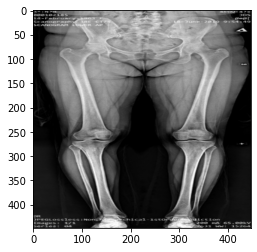

In [30]:
plt.imshow(img)

In [31]:
target.shape

torch.Size([1, 7, 7, 30])

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class yoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    def compute_iou(self, box1, box2):
        '''Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        '''
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        wh = rb - lt  # [N,M,2]
        wh[wh<0] = 0  # clip at 0
        inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

        area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
        area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

        iou = inter / (area1 + area2 - inter)
        return iou
    def forward(self,pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30) [x,y,w,h,c]
        target_tensor: (tensor) size(batchsize,S,S,30)
        '''
        N = pred_tensor.size()[0]
        coo_mask = target_tensor[:,:,:,4] > 0
        noo_mask = target_tensor[:,:,:,4] == 0
        coo_mask = coo_mask.unsqueeze(-1).expand_as(target_tensor)
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)

        coo_pred = pred_tensor[coo_mask].view(-1,30)
        box_pred = coo_pred[:,:10].contiguous().view(-1,5) #box[x1,y1,w1,h1,c1]
        class_pred = coo_pred[:,10:]                       #[x2,y2,w2,h2,c2]
        
        coo_target = target_tensor[coo_mask].view(-1,30)
        box_target = coo_target[:,:10].contiguous().view(-1,5)
        class_target = coo_target[:,10:]

        # compute not contain obj loss
        noo_pred = pred_tensor[noo_mask].view(-1,30)
        noo_target = target_tensor[noo_mask].view(-1,30)
        noo_pred_mask = torch.cuda.ByteTensor(noo_pred.size())
        noo_pred_mask.zero_()
        noo_pred_mask[:,4]=1;noo_pred_mask[:,9]=1
        noo_pred_c = noo_pred[noo_pred_mask] #noo pred只需要计算 c 的损失 size[-1,2]
        noo_target_c = noo_target[noo_pred_mask]
        nooobj_loss = F.mse_loss(noo_pred_c,noo_target_c,size_average=False)

        #compute contain obj loss
        coo_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_response_mask.zero_()
        coo_not_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_not_response_mask.zero_()
        box_target_iou = torch.zeros(box_target.size()).cuda()
        for i in range(0,box_target.size()[0],2): #choose the best iou box
            box1 = box_pred[i:i+2]
            box1_xyxy = Variable(torch.FloatTensor(box1.size()))
            box1_xyxy[:,:2] = box1[:,:2]/14. -0.5*box1[:,2:4]
            box1_xyxy[:,2:4] = box1[:,:2]/14. +0.5*box1[:,2:4]
            box2 = box_target[i].view(-1,5)
            box2_xyxy = Variable(torch.FloatTensor(box2.size()))
            box2_xyxy[:,:2] = box2[:,:2]/14. -0.5*box2[:,2:4]
            box2_xyxy[:,2:4] = box2[:,:2]/14. +0.5*box2[:,2:4]
            iou = self.compute_iou(box1_xyxy[:,:4],box2_xyxy[:,:4]) #[2,1]
            max_iou,max_index = iou.max(0)
            max_index = max_index.data.cuda()
            
            coo_response_mask[i+max_index]=1
            coo_not_response_mask[i+1-max_index]=1

            #####
            # we want the confidence score to equal the
            # intersection over union (IOU) between the predicted box
            # and the ground truth
            #####
            box_target_iou[i+max_index,torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        box_target_iou = Variable(box_target_iou).cuda()
        #1.response loss
        box_pred_response = box_pred[coo_response_mask].view(-1,5)
        box_target_response_iou = box_target_iou[coo_response_mask].view(-1,5)
        box_target_response = box_target[coo_response_mask].view(-1,5)
        contain_loss = F.mse_loss(box_pred_response[:,4],box_target_response_iou[:,4],size_average=False)
        loc_loss = F.mse_loss(box_pred_response[:,:2],box_target_response[:,:2],size_average=False) + F.mse_loss(torch.sqrt(box_pred_response[:,2:4]),torch.sqrt(box_target_response[:,2:4]),size_average=False)
        #2.not response loss
        box_pred_not_response = box_pred[coo_not_response_mask].view(-1,5)
        box_target_not_response = box_target[coo_not_response_mask].view(-1,5)
        box_target_not_response[:,4]= 0
        #not_contain_loss = F.mse_loss(box_pred_response[:,4],box_target_response[:,4],size_average=False)
        
        #I believe this bug is simply a typo
        not_contain_loss = F.mse_loss(box_pred_not_response[:,4], box_target_not_response[:,4],size_average=False)

        #3.class loss
        class_loss = F.mse_loss(class_pred,class_target,size_average=False)

        return (self.l_coord*loc_loss + 2*contain_loss + not_contain_loss + self.l_noobj*nooobj_loss + class_loss)/N


In [33]:
criterion = yoloLoss(7,2,5,0.5)

In [34]:
net.train()
learning_rate = 0.0001
params=[]
params_dict = dict(net.named_parameters())
for key,value in params_dict.items():
    if key.startswith('features'):
        params += [{'params':[value],'lr':learning_rate*1}]
    else:
        params += [{'params':[value],'lr':learning_rate}]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [35]:
num_epochs = 1

for epoch in range(num_epochs):
    total_loss = 0.
    for i,(images,target) in enumerate(train_loader):
        print(images)
        images = torch.Tensor(images)
        images = Variable(images)
        target = Variable(target)
        print(images.shape)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.data[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f' 
            %(epoch+1, num_epochs, i+1, len(train_loader), loss.data[0], total_loss / (i+1)))
#             num_iter += 1
#             vis.plot_train_val(loss_train=total_loss/(i+1))
        
        break

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0471, 0.0510],
          [0.0118, 0.0314, 0.0824,  ..., 0.0588, 0.0392, 0.0549],
          [0.0000, 0.1569, 0.3529,  ..., 0.0627, 0.0235, 0.0353],
          ...,
          [0.0000, 0.0118, 0.0353,  ..., 0.1451, 0.0431, 0.0000],
          [0.2667, 0.3451, 0.4471,  ..., 0.5216, 0.3294, 0.1882],
          [0.0078, 0.0235, 0.0392,  ..., 0.0275, 0.0157, 0.0078]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0471, 0.0510],
          [0.0118, 0.0314, 0.0824,  ..., 0.0588, 0.0392, 0.0549],
          [0.0000, 0.1569, 0.3529,  ..., 0.0627, 0.0235, 0.0353],
          ...,
          [0.0078, 0.0196, 0.0392,  ..., 0.1451, 0.0431, 0.0000],
          [0.2745, 0.3529, 0.4549,  ..., 0.5216, 0.3294, 0.1882],
          [0.0157, 0.0275, 0.0431,  ..., 0.0275, 0.0157, 0.0078]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0471, 0.0510],
          [0.0118, 0.0314, 0.0824,  ..., 0.0588, 0.0392, 0.0549],
          [0.0000, 0.1569, 0.3529,  ..., 0

C:\Users\jyyt0\anaconda3\envs\yolo_tf\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TypeError: type torch.cuda.ByteTensor not available. Torch not compiled with CUDA enabled.